<a href="https://colab.research.google.com/github/baygaliyev/eide/blob/main/missing_emission_data_imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
! pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 16.9 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
  Attempting uninstall: geopandas
    Found existing installation: geopandas 1.0.1
    Uninstalling geopandas-1.0.1:
      Successfully uninstalled geopandas-1.0.1


In [ ]:
import numpy as np
import pandas as pd
import osmnx as ox
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

import xgboost as xgb

from datetime import timedelta
import timeit

# Mount at Google Drive
Google Colab requires to mount the data after every connection. Clicking on the "run" button is enough.

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Preprocessing

**Case 1: Pisa**

In [1]:
city = 'Pisa'
data_path = '/content/drive/MyDrive/Colab Notebooks/phd_data/'

road_segments = pd.read_csv(data_path + 'OSM_{}_raw_segment'.format(city))
road_segments.rename(columns={'s_id': 'start_point', 'e_id': 'end_point'}, inplace=True) # rename some cols to merge with emissions df
road_segments = road_segments.drop({'way_ids', 'bridge', 'maxspeed', 'lanes', 'inc_id'}, axis=1) # trivial cols
print(f"No. of road segments: {road_segments.shape[0]}")
road_segments.head()

In [ ]:
road_segments.columns

Index(['start_point', 'end_point', 's_lon', 's_lat', 'e_lon', 'e_lat', 'c_lon',
       'c_lat', 'length', 'radian', 'highway_cls', 'c-centrality',
       'b-centrality', 'h-centrality', 'degree', 'cultural', 'education',
       'food', 'health', 'service', 'transportation'],
      dtype='object')

In [ ]:
road_segments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5702 entries, 0 to 5701
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   start_point     5702 non-null   int64  
 1   end_point       5702 non-null   int64  
 2   road_link       5702 non-null   object 
 3   length          5702 non-null   float64
 4   cultural        5702 non-null   float64
 5   education       5702 non-null   float64
 6   food            5702 non-null   float64
 7   health          5702 non-null   float64
 8   service         5702 non-null   float64
 9   transportation  5702 non-null   float64
 10  degree          5702 non-null   float64
 11  b-centrality    5702 non-null   float64
 12  c-centrality    5702 non-null   float64
 13  h-centrality    5702 non-null   float64
 14  CO_2/m          5702 non-null   float64
 15  s_lat           5702 non-null   float64
 16  s_lon           5702 non-null   float64
 17  e_lat           5702 non-null   f

In [ ]:
city = 'Pisa'
input_path = '/content/drive/MyDrive/Colab Notebooks/phd_data/imputation/sarn/'
embs_n_co2m = pd.read_csv(input_path+'{}_simple_directed_network_embeddings.csv'.format(city.lower()))
# embs_n_co2m = embs_n_co2m[embs_n_co2m['CO_2/m']<=1]
# carbon_per_meter = embs_n_co2m[['road_link', 'start_point', 'end_point', 'CO_2/m']]
embeddings = embs_n_co2m
print(f"No. of road segments: {embeddings.shape[0]}")
embeddings.head()

No. of road segments: 12043


,start_point,end_point,key,length,oneway,lanes,maxspeed,geometry,simplified_segment_id,vector_0,...,vector_118,vector_119,vector_120,vector_121,vector_122,vector_123,vector_124,vector_125,vector_126,vector_127
0,8437288,346235886,0,768.388,True,2,NaN,LINESTRING (609472.165936708 4830319.036205051...,"(8437288, 346235886, 0)",-0.020982,...,0.021932,-0.156169,0.120895,0.138591,0.017300,0.151953,0.009977,-0.160450,-0.091948,0.039844
1,8437288,367740049,0,745.184,True,2,130,LINESTRING (609472.165936708 4830319.036205051...,"(8437288, 367740049, 0)",-0.057252,...,0.068240,-0.164502,0.103005,0.116652,0.018801,0.135922,0.026254,-0.153106,-0.104921,0.030517
2,31680764,302338593,0,227.699,True,"['2', '3']",50,LINESTRING (615655.1634707755 4838686.10369037...,"(31680764, 302338593, 0)",0.042165,...,0.096613,0.028628,0.019544,0.050344,0.041087,0.138578,0.021367,-0.029848,0.109002,0.032280
3,31680777,1117292464,0,162.006,True,2,NaN,LINESTRING (615687.4668204511 4840295.67884596...,"(31680777, 1117292464, 0)",-0.151568,...,0.122265,0.113445,-0.115014,0.065443,0.014771,0.051441,-0.018294,-0.042812,0.137723,0.002665
4,31680777,3488541943,0,65.969,True,2,50,LINESTRING (615687.4668204511 4840295.67884596...,"(31680777, 3488541943, 0)",-0.124054,...,0.106122,0.117674,-0.119080,0.068734,0.021115,0.071824,-0.030845,-0.032968,0.154654,-0.006603


In [ ]:
embeddings.columns

Index(['start_point', 'end_point', 'key', 'length', 'oneway', 'lanes',
       'maxspeed', 'geometry', 'simplified_segment_id', 'vector_0',
       ...
       'vector_118', 'vector_119', 'vector_120', 'vector_121', 'vector_122',
       'vector_123', 'vector_124', 'vector_125', 'vector_126', 'vector_127'],
      dtype='object', length=137)

In [ ]:
embeddings = embeddings.drop(['length', 'key', 'oneway', 'lanes', 'maxspeed', 'geometry', 'simplified_segment_id'], axis=1)

In [2]:
roads_with_emissions = pd.merge(road_segments, carbon_per_meter, on=['start_point', 'end_point'])
print(f"No. of road segments: {roads_with_emissions.shape[0]}")
roads_with_emissions.head(1)

In [ ]:
# Merge with start_point embeddings
merged_df = road_segments.merge(embeddings, on=['start_point', 'end_point'], how='inner')
# merged_df = merged_df.rename(columns={'embedding': 'start_embedding'})

print(len(merged_df))
# Now merged_df contains road_segments with start_embedding and end_embedding
merged_df.head()

4656


,start_point,end_point,road_link,length,cultural,education,food,health,service,transportation,...,vector_118,vector_119,vector_120,vector_121,vector_122,vector_123,vector_124,vector_125,vector_126,vector_127
0,8437288,346235886,"(8437288, 346235886, 0)",768.388,0.0,0.0,0.0,0.0,0.0,0.0,...,0.021932,-0.156169,0.120895,0.138591,0.017300,0.151953,0.009977,-0.160450,-0.091948,0.039844
1,8437288,367740049,"(8437288, 367740049, 0)",745.184,0.0,0.0,0.0,0.0,0.0,0.0,...,0.068240,-0.164502,0.103005,0.116652,0.018801,0.135922,0.026254,-0.153106,-0.104921,0.030517
2,31680764,302338593,"(31680764, 302338593, 0)",227.699,0.0,0.0,0.0,0.0,0.0,0.0,...,0.096613,0.028628,0.019544,0.050344,0.041087,0.138578,0.021367,-0.029848,0.109002,0.032280
3,31680780,1675060934,"(31680780, 1675060934, 0)",644.319,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.010384,0.027781,-0.075888,0.079615,0.021395,0.063868,0.052965,-0.050480,0.121712,-0.028187
4,31680780,3488541942,"(31680780, 3488541942, 0)",63.263,0.0,0.0,0.0,0.0,0.0,0.0,...,0.111716,0.127332,-0.111027,0.082079,0.010693,0.106627,-0.048729,-0.028443,0.148764,0.007275


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4656 entries, 0 to 4655
Columns: 147 entries, start_point to vector_127
dtypes: float64(144), int64(2), object(1)
memory usage: 5.2+ MB


In [ ]:
city = 'Pisa'
# data_path = '/content/drive/MyDrive/Colab Notebooks/phd_data/input_data/'
file_path = '/content/drive/MyDrive/Colab Notebooks/phd_data/input_data/pisa_features_and_emissions_simple_undirected_network'

data = pd.read_csv(file_path)
# road_segments.rename(columns={'s_id': 'start_point', 'e_id': 'end_point'}, inplace=True) # rename some cols to merge with emissions df
# data['CO_2/m'] = data['CO_2'] / data['length']
data = data.drop({'NO_x', 'PM', 'VOC'}, axis=1) # trivial cols

# Create new columns for start and end coordinates
# road_segments['s_lat'] = road_segments['start_point'].apply(lambda node: G.nodes[node]['y'])
# road_segments['s_lon'] = road_segments['start_point'].apply(lambda node: G.nodes[node]['x'])
# road_segments['e_lat'] = road_segments['end_point'].apply(lambda node: G.nodes[node]['y'])
# road_segments['e_lon'] = road_segments['end_point'].apply(lambda node: G.nodes[node]['x'])
# drop roads with no coordinates

# road_segments = road_segments[road_segments['CO_2/m']<100]

orig_data_size = len(data)
print(f"Original data length: {orig_data_size}")
data.head()

Original data length: 5702


,start_point,end_point,CO_2,road_link,length,oneway,lanes,maxspeed,cultural,education,food,health,service,transportation,degree,b-centrality,c-centrality,h-centrality
0,8437288,346235886,5864.204543,"(8437288, 346235886, 0)",768.388,True,2,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.011526,0.022925,237.277656
1,8437288,367740049,5275.472066,"(8437288, 367740049, 0)",745.184,True,2,130,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.000054,0.022918,235.485157
2,8437288,3118669005,60417.570018,"(8437288, 3118669005, 0)",3981.872,True,"['2', '3']",130,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.012070,0.023447,245.183677
3,31680764,206149014,9890.039951,"(31680764, 206149014, 0)",328.405,True,1,40,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.098791,0.029457,323.941584
4,31680764,218749269,3185.935600,"(31680764, 218749269, 0)",259.022,True,2,50,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.015334,0.028980,317.873908


In [ ]:
city = 'pisa'
region_name ='%s, %s' %(city, city)

# Download the street network
G = ox.graph_from_place(region_name, simplify=False,  retain_all=True, network_type='all')
# G = ox.get_undirected(G)

# Convert the graph to a GeoDataFrame to easily access node data
node_data = ox.graph_to_gdfs(G, nodes=True, edges=False)

def get_node_lat_lon_pisa(node_id):
    # Check if the node ID exists in the graph, then return its lat/lon
    if node_id in node_data.index:
        lat = node_data.loc[node_id, 'y']
        lon = node_data.loc[node_id, 'x']
        return lat, lon
    else:
        #print(f"Node {node_id} not found in Pisa.")
        return 0,0


 ## Preprocess / 1
 * compute new features (central lat-lon, direction and distance w.r.t. center)
 * filter out roads outside the graph (Pisa province)

In [ ]:
start_list = list(data.start_point)
end_list = list(data.end_point)

start_latlon = [get_node_lat_lon_pisa(node_id) for node_id in start_list]
start_lat = [ lat for (lat,lon) in start_latlon ]
start_lon = [ lon for (lat,lon) in start_latlon ]

end_latlon = [get_node_lat_lon_pisa(node_id) for node_id in end_list]
end_lat = [ lat for (lat,lon) in end_latlon ]
end_lon = [ lon for (lat,lon) in end_latlon ]

mid_lat = [ (a+b)/2 for (a,b) in zip(start_lat, end_lat) ]
mid_lon = [ (a+b)/2 for (a,b) in zip(start_lon, end_lon) ]

from statistics import mean, stdev
from numpy import arctan2
from numpy.linalg import norm

data['mid_lat'] = mid_lat
data['mid_lon'] = mid_lon
data['start_lat'] = start_lat
data['end_lat'] = end_lat

data = data[data['start_lat'] != 0]
data = data[data['end_lat'] != 0].drop(columns=['start_lat', 'end_lat'])  # removes 3.03% outliers

data['orientation'] = arctan2(data.mid_lon-mean(data.mid_lon), data.mid_lat-mean(data.mid_lat))
data['dist_center'] = [ norm(p) for p in zip(data.mid_lon-mean(data.mid_lon), data.mid_lat-mean(data.mid_lat)) ]

In [ ]:
print(f"Current data length: {len(data)}")
print(f"Total removed: {(100-100*len(data)/orig_data_size):.2f}%")

Current data length: 5688
Total removed: 0.25%


 ## Preprocess / 2
 * fix issues with: lanes, maxspeed
 * convert CO_2 to CO_2/m
 * filter out outlier CO_2 values (too small or too large)

In [ ]:
data_clean = data[ ['CO_2', 'road_link', 'start_point', 'end_point', 'length', 'oneway', 'lanes', 'maxspeed', 'cultural', 'education',
       'food', 'health', 'service', 'transportation', 'degree', 'b-centrality',
       'c-centrality', 'h-centrality', 'mid_lat', 'mid_lon', 'orientation',
       'dist_center'] ]

import ast
def max_string(el, exceptions={'IT:urban': 50}):
    # Parses the string "el", considering the presence of lists of values or special strings
    if el in exceptions:
        return exceptions[el]
    el = ast.literal_eval(el)
    if type(el) == list:
        el = max([ ast.literal_eval(e) for e in el])
    return el

# Assigns a single numerical value to each instance of "lanes" and "maxspeed"
data_clean['lanes'] = [max_string(el) for el in list(data_clean.lanes)]
data_clean['maxspeed'] = [max_string(el) for el in list(data_clean.maxspeed)]

# Transforms CO_2 to CO_2/m
data_clean['CO_2'] = data_clean['CO_2'] / data_clean['length']
data_clean.rename(columns={'CO_2': 'CO_2/m'}, inplace=True)

# Remove outliers
max_cap = 10.0  # removes 4.59% high outliers
min_cap = 2.5e-2  # removes 3.42% low outliers

data_clean = data_clean[data_clean['CO_2/m']<=max_cap]  # Max cap
data_clean = data_clean[data_clean['CO_2/m']>=min_cap]  # Min cap


Current data length: 5224
Total removed: 8.38%


<Axes: >

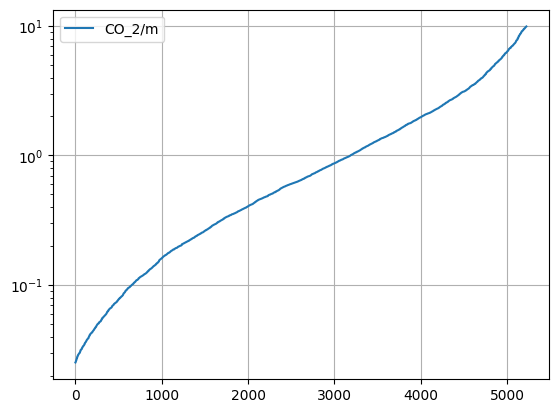

In [ ]:
print(f"Current data length: {len(data_clean)}")
print(f"Total removed: {(100-100*len(data_clean)/orig_data_size):.2f}%")

data_clean['CO_2/m'].sort_values().reset_index().plot(y='CO_2/m', grid=True, logy=True)

------------
**Case 2: Rome**

In [ ]:
# read csv in pandas

city = 'Rome'
data_path = '/content/drive/MyDrive/Colab Notebooks/phd_data/input_data/'

df_emissions = pd.read_csv(data_path + '/rome_weekly_emissions_simple_undirected_network.csv')
print(f"The size of the df: {len(df_emissions)}")
df_emissions.head()

The size of the df: 1250326


,start_point,end_point,week,length,CO_2,NO_x,PM,VOC
0,21637960,347298638,1.0,41.366,2.666664,0.000587,0.000000,0.004473
1,21637960,347298638,2.0,41.366,3.279245,0.000619,0.000000,0.008939
2,21637960,347298638,6.0,41.366,4.167718,0.002433,0.000040,0.013418
3,21637960,347298638,8.0,41.366,5.300154,0.001049,0.000000,0.008945
4,21637960,347298638,9.0,41.366,6.573168,0.002332,0.000019,0.013422


In [ ]:
rome_weekly_carbon = df_emissions[['start_point', 'end_point', 'week', 'length', 'CO_2']]
# Filter out rows where CO_2 is zero
rome_weekly_carbon = rome_weekly_carbon[rome_weekly_carbon['CO_2'] > 0]
print(len(rome_weekly_carbon))
rome_weekly_carbon.head()

1250009


,start_point,end_point,week,length,CO_2
0,21637960,347298638,1.0,41.366,2.666664
1,21637960,347298638,2.0,41.366,3.279245
2,21637960,347298638,6.0,41.366,4.167718
3,21637960,347298638,8.0,41.366,5.300154
4,21637960,347298638,9.0,41.366,6.573168


In [ ]:
rome_weekly_carbon.describe()

,start_point,end_point,week,length,CO_2
count,1.250009e+06,1.250009e+06,1.250009e+06,1.250009e+06,1.250009e+06
mean,1.266143e+09,2.740066e+09,2.757333e+01,1.546517e+02,2.613982e+01
std,2.398583e+09,3.521945e+09,1.504710e+01,2.247407e+02,2.000541e+02
min,2.163796e+07,2.538816e+07,1.000000e+00,5.260000e-01,1.888096e-02
25%,2.625602e+08,3.074494e+08,1.500000e+01,5.423300e+01,1.106000e+00
50%,3.065935e+08,1.107549e+09,2.800000e+01,9.702100e+01,2.289381e+00
75%,9.005234e+08,3.829313e+09,4.100000e+01,1.730550e+02,5.690714e+00
max,1.220145e+10,1.220673e+10,5.200000e+01,7.871125e+03,1.330290e+04


In [ ]:
# Define the start of the year 2017 (Monday is typically the start of the week in ISO calendars)
start_of_year = pd.to_datetime('2017-01-01')
# Calculate the start date of each week
weekly_carbon_df['week_start'] = weekly_carbon_df['week'].apply(lambda x: start_of_year + timedelta(weeks=int(x) - 1))

# Function to determine month based on majority of days in the week
def get_majority_month(week_start):
  week_days = [week_start + timedelta(days=i) for i in range(7)]  # Generate the 7 days of the week
  month_counts = pd.Series([day.month for day in week_days]).value_counts()  # Count days in each month
  return month_counts.idxmax()  # Return the month with the most days

# Map the week to the a month
weekly_carbon_df['month'] = weekly_carbon_df['week_start'].apply(get_majority_month)

estimations_df = weekly_carbon_df.groupby(['start_point', 'end_point', 'month'])['CO_2'].sum().reset_index()
rome_weekly_carbon['CO_2/m'] = rome_weekly_carbon['CO_2'] / rome_weekly_carbon['length']
rome_weekly_carbon = rome_weekly_carbon.drop(['CO_2', 'length'], axis=1)
print(len(estimations_df))
estimations_df.head()

In [ ]:
rome_weekly_carbon['CO_2/m'] = rome_weekly_carbon['CO_2'] / rome_weekly_carbon['length']
rome_weekly_carbon = rome_weekly_carbon.drop(['CO_2', 'length'], axis=1)
rome_weekly_carbon.head()

# save rome_weekly_carbon
# rome_weekly_carbon.to_csv(data_path + 'rome_total_weekly_carbon_simple_undirected_network.csv', index=False)


,start_point,end_point,week,CO_2/m
0,21637960,347298638,1.0,0.064465
1,21637960,347298638,2.0,0.079274
2,21637960,347298638,6.0,0.100752
3,21637960,347298638,8.0,0.128128
4,21637960,347298638,9.0,0.158903


In [ ]:
# # prompt: group df_emissions rows by road_link and sum co_2 no_x pm and voc

# import ast
# df_emissions_grouped = df_emissions.groupby(['road_link', 'week'],
#                                             as_index=False).agg({'CO_2': 'sum', 'NO_x': 'sum', 'PM': 'sum', 'VOC': 'sum'})

# # convert the column
# df_emissions_grouped['road_link'] = df_emissions_grouped['road_link'].apply(ast.literal_eval)
# # Split the tuples into three columns
# df_emissions_grouped[['start_point', 'end_point', 'extra_value']] = pd.DataFrame(df_emissions_grouped['road_link'].tolist(),
#                                                                                  index=df_emissions_grouped.index)

# # some road links have two values: with extra value 1 and 0. Group them
# df_emissions_grouped = df_emissions_grouped.drop('extra_value', axis=1)
# df_emissions_grouped = df_emissions_grouped.groupby(['start_point', 'end_point', 'week'])[['CO_2', 'NO_x', 'PM', 'VOC']].sum().reset_index()

# print(len(df_emissions_grouped))

# df_emissions_grouped.head()

In [ ]:
# read rome_features_and_emissions_simple_undirected_network

file_path = '/content/drive/MyDrive/Colab Notebooks/phd_data/input_data/rome_features_and_emissions_simple_undirected_network'

rome_road_segments = pd.read_csv(file_path)
print(f"No. of road segments: {rome_road_segments.shape[0]}")
rome_road_segments.head()


No. of road segments: 78287


,start_point,end_point,length_x,CO_2,NO_x,PM,VOC,cultural,education,food,...,ev_centrality,pagerank,length_y,oneway,lanes,maxspeed,s_lat,s_lon,e_lat,e_lon
0,21637960,347298638,41.366,196.754968,0.069673,0.001791,0.400776,0.0,0.0,0.0,...,9.150000e-09,0.000012,41.366,True,2,50,41.702112,12.348359,41.702288,12.347919
1,21637960,430875063,3302.976,31852.728330,11.474428,0.148364,57.466363,0.0,0.0,0.0,...,5.800000e-09,0.000010,3302.976,False,2,50,41.702112,12.348359,41.683969,12.379105
2,21637960,2283636929,41.942,130.803522,0.039940,0.000245,0.259510,0.0,0.0,0.0,...,8.260000e-09,0.000010,41.942,True,2,50,41.702112,12.348359,41.702368,12.347989
3,21637971,260980029,191.418,860.956285,0.386061,0.003829,1.833741,0.0,0.0,0.0,...,1.620000e-08,0.000012,191.418,False,2,50,41.712290,12.324954,41.713079,12.322904
4,21637971,2089909166,90.801,314.761078,0.107283,0.000997,0.635340,0.0,0.0,1.0,...,1.080000e-08,0.000012,90.801,False,2,50,41.712290,12.324954,41.711915,12.325926


In [ ]:
rome_road_segments.columns

Index(['start_point', 'end_point', 'length_x', 'CO_2', 'NO_x', 'PM', 'VOC',
       'cultural', 'education', 'food', 'health', 'service', 'transportation',
       'c_centrality', 'ev_centrality', 'pagerank', 'length_y', 'oneway',
       'lanes', 'maxspeed', 's_lat', 's_lon', 'e_lat', 'e_lon'],
      dtype='object')

In [ ]:
rome_road_segments = rome_road_segments.drop(['CO_2', 'NO_x', 'PM', 'VOC', 'length_y', 'oneway'], axis=1)
# Create 'road_link' column
rome_road_segments['road_link'] = list(zip(rome_road_segments['start_point'], rome_road_segments['end_point']))
# Rename the 'length_x' column to 'length'
rome_road_segments = rome_road_segments.rename(columns={'length_x': 'length'})

rome_road_segments.head()

,start_point,end_point,length,cultural,education,food,health,service,transportation,c_centrality,ev_centrality,pagerank,lanes,maxspeed,s_lat,s_lon,e_lat,e_lon,road_link
0,21637960,347298638,41.366,0.0,0.0,0.0,0.0,0.0,0.0,0.013292,9.150000e-09,0.000012,2,50,41.702112,12.348359,41.702288,12.347919,"(21637960, 347298638)"
1,21637960,430875063,3302.976,0.0,0.0,0.0,0.0,0.0,0.0,0.013292,5.800000e-09,0.000010,2,50,41.702112,12.348359,41.683969,12.379105,"(21637960, 430875063)"
2,21637960,2283636929,41.942,0.0,0.0,0.0,0.0,0.0,0.0,0.013471,8.260000e-09,0.000010,2,50,41.702112,12.348359,41.702368,12.347989,"(21637960, 2283636929)"
3,21637971,260980029,191.418,0.0,0.0,0.0,0.0,0.0,1.0,0.013175,1.620000e-08,0.000012,2,50,41.712290,12.324954,41.713079,12.322904,"(21637971, 260980029)"
4,21637971,2089909166,90.801,0.0,0.0,1.0,0.0,0.0,0.0,0.013005,1.080000e-08,0.000012,2,50,41.712290,12.324954,41.711915,12.325926,"(21637971, 2089909166)"


In [ ]:
rome_road_segments.describe()

,start_point,end_point,length,cultural,education,food,health,service,transportation,c_centrality,ev_centrality,pagerank,lanes,maxspeed,s_lat,s_lon,e_lat,e_lon
count,7.828700e+04,7.828700e+04,78287.000000,78287.000000,78287.000000,78287.000000,78287.000000,78287.000000,78287.000000,78287.000000,7.828700e+04,78287.000000,78287.000000,78287.000000,78287.000000,78287.000000,78287.000000,78287.000000
mean,1.772181e+09,3.192501e+09,103.240561,0.012518,0.014013,0.115128,0.011713,0.034476,0.087077,0.014192,4.866315e-05,0.000010,1.409519,37.985553,41.878143,12.486800,41.878173,12.486815
std,2.895232e+09,3.701768e+09,154.314110,0.121082,0.137942,0.521457,0.113148,0.264815,0.404882,0.002028,2.875063e-03,0.000002,0.610258,11.217830,0.069570,0.094806,0.069569,0.094808
min,2.163796e+07,2.538816e+07,0.526000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005659,3.440000e-15,0.000004,1.000000,5.000000,41.656612,12.235429,41.673471,12.236297
25%,2.971400e+08,3.196124e+08,32.329500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012936,2.590000e-09,0.000010,1.000000,30.000000,41.835903,12.425675,41.835927,12.425688
50%,3.222913e+08,1.420460e+09,65.166000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014087,2.900000e-08,0.000011,1.000000,30.000000,41.882827,12.485774,41.882842,12.485723
75%,1.593538e+09,5.422937e+09,119.647000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015435,3.540000e-07,0.000012,2.000000,50.000000,41.922028,12.549865,41.922032,12.549964
max,1.220145e+10,1.220673e+10,7871.125000,4.000000,6.000000,27.000000,4.000000,12.000000,16.000000,0.020798,3.464556e-01,0.000018,14.000000,130.000000,42.095846,12.794595,42.097898,12.808077


In [ ]:
# check largest emission values for each week
for week_number in rome_weekly_carbon['week'].unique():
  df_road_emissions_week = rome_weekly_carbon[rome_weekly_carbon['week'] == week_number]
  df_road_emissions_week = pd.merge(df_road_emissions_week, rome_road_segments, on=['start_point', 'end_point'], how='inner')
  df_sorted = df_road_emissions_week[['CO_2/m']].sort_values(by='CO_2/m', ascending=False)
  print(df_sorted.head(50))
  print()

          CO_2/m
14753  30.106627
9781   28.107598
5047   18.287531
2179   15.372328
11405  15.348547
19341  13.875787
16299  11.060986
19449   9.380176
19340   9.191305
19275   7.594429
13074   6.925174
15632   6.522247
6365    5.915749
1793    5.693055
17985   5.554126
387     5.399120
12506   5.370917
19650   4.954165
14948   4.682458
18240   4.607898
11664   4.476411
1660    4.252007
10783   4.212432
18730   4.096923
3523    4.066858
5544    4.013766
19455   4.008009
8088    3.963952
18290   3.906819
11665   3.774017
3173    3.704360
4985    3.650588
19149   3.548118
17394   3.531660
2329    3.492235
4349    3.368197
276     3.256367
11659   3.163126
994     3.093589
19456   3.031308
16476   2.991167
5298    2.978303
19437   2.945289
16411   2.939447
13539   2.931030
511     2.921697
15852   2.793306
11080   2.762921
11840   2.706089
3530    2.657812

          CO_2/m
15808  25.884490
6765   25.663132
5368   19.964432
20842  16.751664
12203  13.127475
2269   12.908496
20956  12.352

#Prediction of Emissions (without Classification)

In [ ]:
def predict_road_emissions(df_road_emissions, model, ratio=0.9, shuffles=1, messages=True):
  """
  Predict emissions on road segment with no emission data.

  Parameters
    ----------
  df__road__emissions : df

  model : one of sklearn models

  ratio: training data size

  shuffles: the number of shuffles

  Returns
  -------
  Average MAPE (with the standard deviation) and MAE.
  Dataframe with the errors of the last shuffle.
  """
  start = timeit.default_timer() # timer start

  # create lists to save metrics
  mapes, maes = list(), list()

  for s in range(shuffles):
    # Shuffle dataframe using sample function
    df_road_emissions = df_road_emissions.sample(frac=1).reset_index(drop=True)

    # Split data into test and train
    total_rows = df_road_emissions.shape[0]
    train_size = int(total_rows*ratio)

    embs_n_co2m_train = df_road_emissions[0:train_size]
    embs_n_co2m_test = df_road_emissions[train_size:]

    # Extract feature and target arrays
    X_train, y_train = embs_n_co2m_train.drop(['road_link', 'start_point', 'end_point', 'CO_2/m'],\
                                                axis=1), embs_n_co2m_train['CO_2/m']
    X_test, y_test = embs_n_co2m_test.drop(['road_link', 'start_point', 'end_point', 'CO_2/m'],\
                                            axis=1), embs_n_co2m_test['CO_2/m']
    y_train_log = np.log(y_train)

    regressor = model
    regressor.fit(X_train, y_train_log)

    preds = np.exp(regressor.predict(X_test))

    mape, mae = metrics.mean_absolute_percentage_error(y_test, preds), metrics.mean_absolute_error(y_test, preds)

    mapes.append(mape)
    maes.append(mae)
    if messages == True:
      print("Round %s\n------- \nMAPE %.2f%%\nMAE:  %.2f%%\n" %(s, mape*100, mae*100))

  # save predicted emission amounts and prediction errors
  prediction_errors = pd.DataFrame(data={"road_link":embs_n_co2m_test.road_link, "start_point":embs_n_co2m_test.start_point,
                              "end_point":embs_n_co2m_test.end_point, "CO_2/m":embs_n_co2m_test['CO_2/m'], "carbon_predicted":preds})

  prediction_errors['difference'] = abs(prediction_errors['CO_2/m'] - prediction_errors['carbon_predicted'])
  prediction_errors['percent_error'] = prediction_errors['difference'] / prediction_errors['CO_2/m'] * 100

  stop = timeit.default_timer() # timer stop
  print('Time: %.0f seconds' %(stop - start))
  # print(mapes, maes)
  print("Mean MAPE is %.2f\%% (%.2f\%%), mean MAE is %.2f%%"\
        %(np.mean(mapes)*100, np.std(mapes)*100, np.mean(maes)*100))
  print()

  return prediction_errors

In [ ]:
# linear regression
model = linear_model.LinearRegression()
prediction_errors = predict_road_emissions(road_segments, model, ratio = 0.9, shuffles = 10, messages=False)

Time: 0 seconds
Mean MAPE is 385.58\% (57.74\%), mean MAE is 193.19%


In [ ]:
# xgboost
model = xgb.XGBRegressor(learning_rate = 0.05, n_estimators = 500, max_depth = 6, eval_metric='mape')
prediction_errors = predict_road_emissions(road_segments, model, ratio=0.9, shuffles=10, messages=False)

Time: 18 seconds
Mean MAPE is 239.43\% (92.55\%), mean MAE is 154.38%


In [ ]:
import numpy as np
import pandas as pd

# Initialize a list to store results for each week
weekly_results = []

# Function to predict emissions for a specific week
def predict_emissions_for_week(df_road_emissions_week, model, ratio=0.9, shuffles=10, messages=False):
    """
    Predict emissions for a specific week using the predict_road_emissions function.
    """
    return predict_road_emissions(df_road_emissions_week, model, ratio, shuffles, messages)


# Loop through each week and predict emissions
for week_number in rome_weekly_carbon['week'].unique():
    print(f"Predicting emissions for week: {week_number}")

    # Filter data for the current week
    df_road_emissions_week = rome_weekly_carbon[rome_weekly_carbon['week'] == week_number]
    df_road_emissions_week = pd.merge(df_road_emissions_week, rome_road_segments, on=['start_point', 'end_point'], how='inner')

    df_road_emissions_week['CO_2/m'] = df_road_emissions_week['CO_2'] / df_road_emissions_week['length']
    df_road_emissions_week = df_road_emissions_week.drop(['CO_2'], axis=1)

    # Ensure we have data to process
    if df_road_emissions_week.empty:
        print(f"No data available for week {week_number}, skipping this week.")
        continue  # Skip to the next week if the dataset is empty

    # Regressor model
    regressor = xgb.XGBRegressor(learning_rate=0.05, n_estimators=500, max_depth=6, eval_metric='mape')

    # Call the function to predict emissions for the current week
    prediction_errors = predict_emissions_for_week(df_road_emissions_week, regressor, ratio=0.9, shuffles=10, messages=False)

    # Extract mean MAPE and MAE for the current week
    mean_mape = np.mean(prediction_errors['percent_error'])  # Assuming 'percent_error' is in prediction_errors
    mean_mae = np.mean(prediction_errors['difference'])      # Assuming 'difference' is in prediction_errors

    # Store the results for the current week
    weekly_results.append({'week': week_number, 'MAPE': mean_mape, 'MAE': mean_mae})

    print(f"Week {week_number}: MAPE = {mean_mape:.2f}%, MAE = {mean_mae:.2f}%")

# Convert the results to a DataFrame
weekly_results_df = pd.DataFrame(weekly_results)

# Calculate the overall mean MAPE and MAE across all weeks
mean_mape_all = weekly_results_df['MAPE'].mean()
mean_mae_all = weekly_results_df['MAE'].mean()

# Print the overall results
print(f"\nOverall Mean MAPE across all weeks: {mean_mape_all:.2f}%")
print(f"Overall Mean MAE across all weeks: {mean_mae_all:.2f}%")

path = '/content/drive/MyDrive/Colab Notebooks/phd_data/imputation/xgb_xgb/'
# Optionally, save the weekly results to a CSV file
weekly_results_df.to_csv(path + 'rome_weekly_carbon_xgb_results.csv', index=False)


Predicting emissions for week: 1.0
Time: 22 seconds
Mean MAPE is 104.73\% (7.12\%), mean MAE is 5.79%

Week 1.0: MAPE = 102.74%, MAE = 0.06%
Predicting emissions for week: 2.0
Time: 28 seconds
Mean MAPE is 106.13\% (8.52\%), mean MAE is 5.45%

Week 2.0: MAPE = 109.28%, MAE = 0.06%
Predicting emissions for week: 3.0
Time: 21 seconds
Mean MAPE is 102.45\% (4.25\%), mean MAE is 6.27%

Week 3.0: MAPE = 98.27%, MAE = 0.07%
Predicting emissions for week: 4.0
Time: 25 seconds
Mean MAPE is 103.98\% (7.01\%), mean MAE is 6.92%

Week 4.0: MAPE = 93.98%, MAE = 0.06%
Predicting emissions for week: 5.0
Time: 25 seconds
Mean MAPE is 109.41\% (5.02\%), mean MAE is 8.38%

Week 5.0: MAPE = 106.92%, MAE = 0.07%
Predicting emissions for week: 6.0
Time: 22 seconds
Mean MAPE is 107.82\% (9.09\%), mean MAE is 6.69%

Week 6.0: MAPE = 96.62%, MAE = 0.07%
Predicting emissions for week: 7.0
Time: 24 seconds
Mean MAPE is 100.63\% (3.82\%), mean MAE is 6.44%

Week 7.0: MAPE = 97.80%, MAE = 0.06%
Predicting emissi

In [ ]:
# prompt: # Print the overall results
# print(f"\nOverall Mean MAPE across all weeks: {mean_mape_all:.2f}%")
# make this for min and max too

# Calculate the overall mean MAPE and MAE across all weeks
mean_mape_all = weekly_results_df['MAPE'].mean()
mean_mae_all = weekly_results_df['MAE'].mean()
min_mape_all = weekly_results_df['MAPE'].min()
max_mape_all = weekly_results_df['MAPE'].max()
min_mae_all = weekly_results_df['MAE'].min()
max_mae_all = weekly_results_df['MAE'].max()

# Print the overall results
print(f"\nOverall Mean MAPE across all weeks: {mean_mape_all:.2f}%")
print(f"Overall Min MAPE across all weeks: {min_mape_all:.2f}%")
print(f"Overall Max MAPE across all weeks: {max_mape_all:.2f}%")
print(f"Overall Mean MAE across all weeks: {mean_mae_all:.2f}%")
print(f"Overall Min MAE across all weeks: {min_mae_all:.2f}%")
print(f"Overall Max MAE across all weeks: {max_mae_all:.2f}%")



Overall Mean MAPE across all weeks: 102.76%
Overall Min MAPE across all weeks: 92.20%
Overall Max MAPE across all weeks: 115.39%
Overall Mean MAE across all weeks: 0.07%
Overall Min MAE across all weeks: 0.04%
Overall Max MAE across all weeks: 0.11%


In [ ]:
# save predicted CO2 and errors

emission_errors = pd.DataFrame(data={"road_link":emission_roads_test.road_link, "start_point":emission_roads_test.start_point,
                            "end_point":emission_roads_test.end_point, "CO_2/m":emission_roads_test['CO_2/m'], "prediction":preds})

emission_errors['difference'] = abs(emission_errors['CO_2/m'] - emission_errors['prediction']) # ABSOLUTE NEEDED ?
emission_errors['percent_error'] = (emission_errors['difference'] / emission_errors['CO_2/m']) * 100
emission_errors

In [ ]:
# svm regression
model = make_pipeline(SVR(C=1.0, epsilon=0.2))
prediction_errors = predict_road_emissions(roads_with_emissions, model, ratio=0.9, shuffles=10, messages=False)

Time: 474 seconds
Mean MAPE is 255.57% (std is 7.135%), mean MAE is 139.76%


In [ ]:
# Multi-layer Perceptron regressor

params = { 'hidden_layer_sizes' : [120,80,40],
    'activation' : 'relu', 'solver' : 'adam',
    'alpha' : 0.0001, 'batch_size' : 10,
    'random_state' : 0, 'tol' : 0.0001,
    'nesterovs_momentum' : False,
    'learning_rate' : 'constant',
    'learning_rate_init' : 0.01,
    'max_iter' : 200, 'shuffle' : True,
    'n_iter_no_change' : 50, 'verbose' : False }


model = MLPRegressor(**params)
prediction_errors = predict_road_emissions(roads_with_emissions, model, ratio=0.9, shuffles=2, messages=False)

Time: 936 seconds
Mean MAPE is 198.65\% (0.74\%), mean MAE is 137.32%


In [ ]:
# running in the remote machine

x = roads_with_emissions.drop(['road_link', 'start_point', 'end_point', 'CO_2/m'], axis=1)
y = roads_with_emissions['CO_2/m']
trainX, testX, trainY, testY = train_test_split(x, y, test_size = 0.1)

param_grid = {
    'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [50, 100],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

grid = GridSearchCV(model, param_grid, n_jobs= -1, cv=5)
grid.fit(trainX, trainY)

print(grid.best_params_)

# {'alpha': 0.0001, 'hidden_layer_sizes': (120, 80, 40), 'learning_rate': 'constant', 'max_iter': 200}


#Prediction of Emissions with Classification
The difference of this approach is that roads are grouped into 'low-emission' or 'high-emission' depending on the emission amount (defined by a threshold). Then, low-/high-emission roads are trained in separate models.  

After this, we train a classification model to recognize an emission class of each road in the test dataset.

After the classification, emission amount on each road is estimated based on the emission class predicted on the road.

In [ ]:
def predict_classified_road_emissions(df_road_emissions, classifier, regressor, ratio=0.9, theta=4.2, shuffles=1, messages=False):
  """
  Predict emissions on road segment with no emission data.

  Parameters
    ----------
  df__road__emissions : df

  regressor : one of sklearn models

  ratio: the size of the training dataset

  theta: threshold value between low and high emission values (grams)

  shuffles: the number of shuffles

  Returns
  -------
  Average MAPE (with the standard deviation) and MAE.
  Dataframe with the errors of the last shuffle.
  """

  start = timeit.default_timer() # timer start

  # classification of emissions based on the amount
  labels = df_road_emissions[['CO_2/m']].apply(lambda x: pd.cut(x, [-np.inf, theta, np.inf], labels = [0, 1]))
  df_road_emissions = pd.concat([df_road_emissions, labels.add_suffix('_class')], axis = 1)
  df_road_emissions = df_road_emissions.rename(columns={'CO_2/m_class':'emission_class'})

  # create lists to save metrics
  mapes = {"low": list(), "high": list(), "all": list()}
  maes = {"low": list(), "high": list()}


  for s in range(shuffles):
    # low/high prediction_errors
    prediction_errors = {"low": "prediction_errors_low",
                         "high": "prediction_errors_high", "all": "prediction_errors_all"}

    # Shuffle dataframe using sample function
    df_road_emissions_copy = df_road_emissions.sample(frac=1).reset_index(drop=True)

    # Split data into test and train
    total_rows = df_road_emissions_copy.shape[0]
    train_size = int(total_rows*ratio)
    df_road_emissions_train = df_road_emissions_copy[0:train_size]
    df_road_emissions_test = df_road_emissions_copy[train_size:]

    # Create a dict of emissions of neighboring road segments for each road segment
    # emission values of test samples should not be included
    print("Creating aggregations of emission values of neighboring roads for each road segment.\nEmissions of the test samples are not included.")
    edge_dict = dict()

    for row in df_road_emissions_copy.index:
      road_link = df_road_emissions_copy.iloc[row]['road_link']
      edge_dict[road_link] = []

      start_point = df_road_emissions_copy.iloc[row]['start_point']
      end_point = df_road_emissions_copy.iloc[row]['end_point']

      # xor condition to exclude the road itself from the list of neighbor roads
      neighbors_df = df_road_emissions_train.loc[(df_road_emissions_train['start_point'] == start_point) ^ (df_road_emissions_train['end_point'] == end_point)]
      edge_dict[road_link].append(neighbors_df[['CO_2/m']].values)

    for key in edge_dict.keys():
      if len(edge_dict[key][0]) == 0:
        edge_dict[key][0] = np.nan

    stats = list()

    for key, value in edge_dict.items():
      d = {'road_link': key, 'mean_neighbor_carbon': np.mean(value), 'std_neighbor_carbon': np.std(value),\
          'max_neighbor_carbon': np.max(value), 'min_neighbor_carbon': np.min(value), 'neighbor_count': np.count_nonzero(~np.isnan(value))}
      stats.append(d)

    neighbor_emissions_df = pd.DataFrame.from_dict(stats).fillna(0)
    df_road_emissions_copy = pd.merge(df_road_emissions_copy, neighbor_emissions_df, on=['road_link'])

    # split the dataset again with new features
    df_road_emissions_train = df_road_emissions_copy[0:train_size]
    df_road_emissions_test = df_road_emissions_copy[train_size:]

    # check what happens if roads with no neighbor info are dropped
    df_road_emissions_train = df_road_emissions_train[df_road_emissions_train['neighbor_count'] == 0]
    df_road_emissions_test = df_road_emissions_test[df_road_emissions_test['neighbor_count'] == 0]

    # Extract feature and target arrays
    X_train, y_train = df_road_emissions_train.drop(['road_link', 'start_point', 'end_point', 'CO_2/m', 'emission_class'],\
                                                  axis=1), df_road_emissions_train['emission_class']
    X_test, y_test = df_road_emissions_test.drop(['road_link', 'start_point', 'end_point', 'CO_2/m','emission_class'],\
                                              axis=1), df_road_emissions_test['emission_class']

    # train and test the classifier
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    preds = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, preds)
    print("Accuracy of the classification: %.2f%%" % (accuracy*100))
    df_road_emissions_test['predicted_class'] = preds

    # split the dataset into low and high emissions
    for e_number, e_class in enumerate(['low','high']):
      emission_roads_train = df_road_emissions_train[df_road_emissions_train['emission_class']==e_number]
      emission_roads_test = df_road_emissions_test[df_road_emissions_test['predicted_class']==e_number]  # emission_class / prediction

      X_train_regr, y_train_regr = emission_roads_train.drop(['road_link', 'start_point', 'end_point', 'CO_2/m', 'emission_class'], axis=1), emission_roads_train['CO_2/m']
      X_test_regr, y_test_regr = emission_roads_test.drop(['road_link', 'start_point', 'end_point', 'CO_2/m', 'emission_class', 'predicted_class'], axis=1), emission_roads_test['CO_2/m']

      y_train_regr = np.log(y_train_regr)

      # train the regressor
      regressor.fit(X_train_regr, y_train_regr)
      preds_regr = np.exp(regressor.predict(X_test_regr))

      # calculate and report testing results
      mape, mae = metrics.mean_absolute_percentage_error(y_test_regr, preds_regr), metrics.mean_absolute_error(y_test_regr, preds_regr)
      mapes[e_class].append(mape)
      maes[e_class].append(mae)

      if messages == True:
        print("Round %s\n------- \nMAPE %.2f%%\nMAE:  %.2f%%\n" %(s, mape*100, mae*100))

      # save predicted emission amounts and prediction errors
      prediction_errors[e_class] = pd.DataFrame(data={"road_link":emission_roads_test.road_link, "start_point":emission_roads_test.start_point,
                                            "end_point":emission_roads_test.end_point, "CO_2/m":emission_roads_test['CO_2/m'],
                                            "emission_class":emission_roads_test.emission_class, "predicted_class":emission_roads_test.predicted_class,
                                            "carbon_predicted":preds_regr})


      prediction_errors[e_class]['difference'] = abs(prediction_errors[e_class]['CO_2/m'] - prediction_errors[e_class]['carbon_predicted'])
      prediction_errors[e_class]['percent_error'] = prediction_errors[e_class]['difference'] / prediction_errors[e_class]['CO_2/m'] * 100

    prediction_errors['all'] = pd.concat([prediction_errors['low'], prediction_errors['high']], ignore_index=True, sort=False)
    mapes['all'].append(np.mean(prediction_errors['all']['percent_error']))

  for e_class in ['low','high']:
    print("\nFor %s-emission roads, mean MAPE is %.2f\%% (%.3f\%%), mean MAE is %.2f%%"\
          %(e_class, np.mean(mapes[e_class])*100, np.std(mapes[e_class])*100, np.mean(maes[e_class])*100))
  print("\nMAPE for all roads is %.2f\%% (%.3f\%%)\n" %(np.mean(mapes['all']), np.std(mapes['all'])))

  stop = timeit.default_timer() # timer stop
  print('Time: %.0f seconds' %(stop - start))
  print()

  return prediction_errors

In [ ]:
# Function to predict emissions for a specific month
def predict_emissions_for_month(df_road_emissions_month, classifier, regressor, ratio=0.9, theta=10, shuffles=1, messages=False):
    """
    Predict emissions for a specific month using the predict_classified_road_emissions function.
    """
    return predict_classified_road_emissions(df_road_emissions_month, classifier, regressor, ratio, theta, shuffles, messages)


# Loop through each month and predict emissions
for month_number in rome_monthly_carbon['month'].unique():
    print(f"Predicting emissions for month: {month_number}")

    # Filter data for the current month
    df_road_emissions_month = rome_monthly_carbon[rome_monthly_carbon['month'] == month_number]
    df_road_emissions_month = pd.merge(df_road_emissions_month, rome_road_segments, on=['start_point', 'end_point'], how='inner')

    outlier = df_road_emissions_month['CO_2/m'].quantile(0.995)
    print(f"99.5th quantile of CO_2/m: {outlier}")
    print()
    df_road_emissions_month = df_road_emissions_month[df_road_emissions_month['CO_2/m'] <= 10]

    percentile = df_road_emissions_month['CO_2/m'].quantile(0.8)
    values_above_percentile = df_road_emissions_month[df_road_emissions_month['CO_2/m'] > percentile]
    values_below_percentile = df_road_emissions_month[df_road_emissions_month['CO_2/m'] <= percentile]
    print(f"Threshold value of CO_2/m: {percentile}, {len(values_above_percentile)} vs {len(values_below_percentile)}")

    # Ensure we have data to process
    if df_road_emissions_month.empty:
        print(f"No data available for month {month_number}, skipping this month.")
        continue  # Skip to the next month if the dataset is empty

    # Your classifier and regressor models
    classifier = xgb.XGBClassifier(learning_rate=0.1, n_estimators=250, max_depth=10,
                                   min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                   objective='binary:logistic')
    regressor = xgb.XGBRegressor(learning_rate=0.05, n_estimators=500, max_depth=6, eval_metric='mape')

    # Call the function to predict emissions for the current month
    prediction_errors = predict_emissions_for_month(df_road_emissions_month, classifier, regressor, ratio=0.9,
                                                    theta=percentile, shuffles=1, messages=False)
    # Store or analyze prediction_errors for the current month
    # ...


In [ ]:
# prompt: i need the same code but in a loop because emissions are weekly. i need to run the function for each week

# ... (Your existing code for data loading and preprocessing) ...


# Function to predict emissions for a specific week
def predict_emissions_for_week(df_road_emissions_week, classifier, regressor, ratio=0.9, theta=10, shuffles=1, messages=False):
  """
  Predict emissions for a specific week using the predict_classified_road_emissions function.
  """
  return predict_classified_road_emissions(df_road_emissions_week, classifier, regressor, ratio, theta, shuffles, messages)


# Loop through each week and predict emissions
for week_number in rome_weekly_carbon['week'].unique():
  print(f"Predicting emissions for week: {week_number}")

  # Filter data for the current week
  df_road_emissions_week = rome_weekly_carbon[rome_weekly_carbon['week'] == week_number]
  df_road_emissions_week = pd.merge(df_road_emissions_week, rome_road_segments, on=['start_point', 'end_point'], how='inner')

  outlier = df_road_emissions_week['CO_2/m'].quantile(0.995)
  print(f"99.5th quantile of CO_2/m: {outlier}")
  print()
  df_road_emissions_week = df_road_emissions_week[df_road_emissions_week['CO_2/m'] <= 10]

  percentile = df_road_emissions_week['CO_2/m'].quantile(0.8)
  values_above_percentile = df_road_emissions_week[df_road_emissions_week['CO_2/m'] > percentile]
  values_below_percentile = df_road_emissions_week[df_road_emissions_week['CO_2/m'] <= percentile]
  print(f"Threshold value of CO_2/m: {percentile}, {len(values_above_percentile)} vs {len(values_below_percentile)}")

  # Ensure we have data to process
  if df_road_emissions_week.empty:
      print(f"No data available for week {week_number}, skipping this week.")
      continue  # Skip to the next week if the dataset is empty

  # Your classifier and regressor models
  classifier = xgb.XGBClassifier(learning_rate=0.1, n_estimators=250, max_depth=10,
                                min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                objective='binary:logistic')
  regressor = xgb.XGBRegressor(learning_rate=0.05, n_estimators=500, max_depth=6, eval_metric='mape')

  # Call the function to predict emissions for the current week
  prediction_errors = predict_emissions_for_week(df_road_emissions_week, classifier, regressor, ratio=0.9,
                                                theta=percentile, shuffles=1, messages=False)
  # Store or analyze prediction_errors for the current week
  # ...


Predicting emissions for week: 1.0
99.5th quantile of CO_2/m: 1.8001581182141646

Threshold value of CO_2/m: 0.08257305961326183, 3946 vs 15783
Creating aggregations of emission values of neighboring roads for each road segment.
Emissions of the test samples are not included.
Accuracy of the classification: 87.86%

For low-emission roads, mean MAPE is 70.59\% (0.000\%), mean MAE is 3.92%

For high-emission roads, mean MAPE is 1539.28\% (0.000\%), mean MAE is 35.05%

MAPE for all roads is 136.77\% (0.000\%)

Time: 35 seconds

Predicting emissions for week: 2.0
99.5th quantile of CO_2/m: 1.830274455104672

Threshold value of CO_2/m: 0.0821140568976295, 4256 vs 17021
Creating aggregations of emission values of neighboring roads for each road segment.
Emissions of the test samples are not included.
Accuracy of the classification: 86.09%

For low-emission roads, mean MAPE is 73.60\% (0.000\%), mean MAE is 5.23%

For high-emission roads, mean MAPE is 377.32\% (0.000\%), mean MAE is 13.77%

M

KeyboardInterrupt: 

In [ ]:
# xgboost classifier, xgb regressor different thetas

classifier = xgb.XGBClassifier(learning_rate=0.1, n_estimators=250, max_depth=10,
                          min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                          objective='binary:logistic')
regressor = xgb.XGBRegressor(learning_rate = 0.05, n_estimators = 500, max_depth = 6, eval_metric='mape')

thetas = [0.030426, 4.2]
for theta in thetas:
  prediction_errors = predict_classified_road_emissions(data_clean, classifier, regressor, ratio=0.9,
                                                      theta=theta, shuffles=2, messages=False)

Creating aggregations of emission values of neighboring roads for each road segment.
Emissions of the test samples are not included.
Accuracy of the classification: 97.73%
Creating aggregations of emission values of neighboring roads for each road segment.
Emissions of the test samples are not included.
Accuracy of the classification: 96.74%

For low-emission roads, mean MAPE is 43.13\% (42.226\%), mean MAE is 8.53%

For high-emission roads, mean MAPE is 192.26\% (4.263\%), mean MAE is 88.87%

MAPE for all roads is 190.61\% (3.783\%)

Time: 23 seconds

Creating aggregations of emission values of neighboring roads for each road segment.
Emissions of the test samples are not included.
Accuracy of the classification: 96.81%
Creating aggregations of emission values of neighboring roads for each road segment.
Emissions of the test samples are not included.
Accuracy of the classification: 97.94%

For low-emission roads, mean MAPE is 215.43\% (12.811\%), mean MAE is 65.14%

For high-emission 

In [ ]:
np.percentile(data_clean['CO_2/m'], 1)

0.030426048453717904

In [ ]:
# xgboost classifier, xgb regressor different thetas

classifier = xgb.XGBClassifier(learning_rate=0.1, n_estimators=250, max_depth=10,
                          min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                          objective='binary:logistic')
regressor = xgb.XGBRegressor(learning_rate = 0.05, n_estimators = 500, max_depth = 6, eval_metric='mape')

thetas = [0.15, 0.17, 0.2, 0.3]
for theta in thetas:
  prediction_errors = predict_classified_road_emissions(roads_with_emissions, classifier, regressor, ratio=0.9,
                                                      theta=theta, shuffles=1, messages=False)

Creating aggregations of emission values of neighboring roads for each road segment.
Emissions of the test samples are not included.
Accuracy of the classification: 81.60%
For low-emission roads, mean MAPE is 79.26\% (0.000\%), mean MAE is 20.33%
For high-emission roads, mean MAPE is 216.08\% (0.000\%), mean MAE is 115.65%
MAPE for all roads is 190.56\% (0.000\%)
Time: 179 seconds
Creating aggregations of emission values of neighboring roads for each road segment.
Emissions of the test samples are not included.
Accuracy of the classification: 79.05%
For low-emission roads, mean MAPE is 90.01\% (0.000\%), mean MAE is 19.24%
For high-emission roads, mean MAPE is 241.91\% (0.000\%), mean MAE is 106.85%
MAPE for all roads is 207.47\% (0.000\%)
Time: 191 seconds
Creating aggregations of emission values of neighboring roads for each road segment.
Emissions of the test samples are not included.
Accuracy of the classification: 78.61%
For low-emission roads, mean MAPE is 94.59\% (0.000\%), mean

In [ ]:
 # xgboost classifier, linear regressor

classifier = xgb.XGBClassifier(learning_rate=0.065, n_estimators=250, max_depth=10,
                          min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                          objective='binary:logistic')
regressor = linear_model.LinearRegression()

prediction_errors = predict_classified_road_emissions(road_segments, classifier, regressor, ratio=0.9,
                                                      shuffles=1, messages=False)

Creating aggregations of emission values of neighboring roads for each road segment.
Emissions of the test samples are not included.
Accuracy of the classification: 90.48%

For low-emission roads, mean MAPE is 258.77\% (0.000\%), mean MAE is 112.15%

For high-emission roads, mean MAPE is 1755.62\% (0.000\%), mean MAE is 662.35%

MAPE for all roads is 294.41\% (0.000\%)

Time: 15 seconds


In [3]:
# xgboost classifier, xgb regressor

classifier = xgb.XGBClassifier(learning_rate=0.1, n_estimators=250, max_depth=10,
                          min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                          objective='binary:logistic')
regressor = xgb.XGBRegressor(learning_rate = 0.05, n_estimators = 500, max_depth = 6, eval_metric='mape')

prediction_errors = predict_classified_road_emissions(embeddings, classifier, regressor, ratio=0.9,
                                                      theta=4.2, shuffles=5, messages=False)

In [ ]:
# xgboost classifier, svm regressor
classifier = xgb.XGBClassifier(learning_rate=0.065, n_estimators=250, max_depth=10,
                          min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                          objective='binary:logistic')
regressor = make_pipeline(SVR(C=1.0, epsilon=0.2))

prediction_errors = predict_classified_road_emissions(roads_with_emissions, classifier, regressor, ratio=0.9,
                                                      theta=4, shuffles=10, messages=False)

Accuracy of the classification: 91.56%

Training and testing the a regressor for low emissions:


Training and testing the a regressor for high emissions:

Accuracy of the classification: 92.24%

Training and testing the a regressor for low emissions:


Training and testing the a regressor for high emissions:

Accuracy of the classification: 91.63%

Training and testing the a regressor for low emissions:


Training and testing the a regressor for high emissions:

Accuracy of the classification: 91.63%

Training and testing the a regressor for low emissions:


Training and testing the a regressor for high emissions:

Accuracy of the classification: 90.86%

Training and testing the a regressor for low emissions:


Training and testing the a regressor for high emissions:

Accuracy of the classification: 91.43%

Training and testing the a regressor for low emissions:


Training and testing the a regressor for high emissions:

Accuracy of the classification: 92.64%

Training and testing the

In [ ]:
classifier = xgb.XGBClassifier(learning_rate=0.065, n_estimators=250, max_depth=10,
                          min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                          objective='binary:logistic')

params = { 'hidden_layer_sizes' : [120,80,40],
    'activation' : 'relu', 'solver' : 'adam',
    'alpha' : 0.0001, 'batch_size' : 10,
    'random_state' : 0, 'tol' : 0.0001,
    'nesterovs_momentum' : False,
    'learning_rate' : 'constant',
    'learning_rate_init' : 0.05,
    'max_iter' : 200, 'shuffle' : True,
    'n_iter_no_change' : 50, 'verbose' : False }


regressor = MLPRegressor(**params)

prediction_errors = predict_classified_road_emissions(roads_with_emissions, classifier, regressor, ratio=0.9,
                                                      theta=4, shuffles=10, messages=False)

Accuracy of the classification: 92.40%

Training and testing the a regressor for low emissions:


Training and testing the a regressor for high emissions:

Accuracy of the classification: 92.44%

Training and testing the a regressor for low emissions:


Training and testing the a regressor for high emissions:

Accuracy of the classification: 91.76%

Training and testing the a regressor for low emissions:


Training and testing the a regressor for high emissions:

Accuracy of the classification: 91.03%

Training and testing the a regressor for low emissions:


Training and testing the a regressor for high emissions:

Accuracy of the classification: 91.66%

Training and testing the a regressor for low emissions:


Training and testing the a regressor for high emissions:

Accuracy of the classification: 91.29%

Training and testing the a regressor for low emissions:


Training and testing the a regressor for high emissions:

Accuracy of the classification: 91.39%

Training and testing the

#Imputation of CO2/m Values

In [ ]:
# read rome_total_weekly_carbon_simple_undirected_network and name it weekly_carbon_df

data_path = '/content/drive/MyDrive/Colab Notebooks/phd_data/input_data/'
weekly_carbon_df = pd.read_csv(data_path + 'rome_total_weekly_carbon_simple_undirected_network.csv')
print(weekly_carbon_df.shape)
weekly_carbon_df.head()

(1250009, 4)


,start_point,end_point,week,CO_2/m
0,21637960,347298638,1.0,0.064465
1,21637960,347298638,2.0,0.079274
2,21637960,347298638,6.0,0.100752
3,21637960,347298638,8.0,0.128128
4,21637960,347298638,9.0,0.158903


In [ ]:
# Define the start of the year 2017 (Monday is typically the start of the week in ISO calendars)
start_of_year = pd.to_datetime('2017-01-01')
# Calculate the start date of each week
weekly_carbon_df['week_start'] = weekly_carbon_df['week'].apply(lambda x: start_of_year + timedelta(weeks=int(x) - 1))

# Function to determine month based on majority of days in the week
def get_majority_month(week_start):
  week_days = [week_start + timedelta(days=i) for i in range(7)]  # Generate the 7 days of the week
  month_counts = pd.Series([day.month for day in week_days]).value_counts()  # Count days in each month
  return month_counts.idxmax()  # Return the month with the most days

# Map the week to the a month
weekly_carbon_df['month'] = weekly_carbon_df['week_start'].apply(get_majority_month)
weekly_carbon_df.head()

,start_point,end_point,week,CO_2/m,week_start,month
0,21637960,347298638,1.0,0.064465,2017-01-01,1
1,21637960,347298638,2.0,0.079274,2017-01-08,1
2,21637960,347298638,6.0,0.100752,2017-02-05,2
3,21637960,347298638,8.0,0.128128,2017-02-19,2
4,21637960,347298638,9.0,0.158903,2017-02-26,3


In [ ]:
monthly_carbon_df = weekly_carbon_df.groupby(['start_point', 'end_point', 'month'])['CO_2/m'].mean().reset_index()
monthly_carbon_df.head()

,start_point,end_point,month,CO_2/m
0,21637960,347298638,1,0.071870
1,21637960,347298638,2,0.114440
2,21637960,347298638,3,0.100816
3,21637960,347298638,4,0.075915
4,21637960,347298638,5,0.031803


In [ ]:
# read rome_features_simple_undirected_network and name it features_df

features_df = pd.read_csv(data_path + 'rome_features_simple_undirected_network.csv')
print(features_df.shape)
features_df.head()

(95632, 19)


,start_point,end_point,c_centrality,ev_centrality,pagerank,cultural,education,food,health,service,transportation,length,oneway,lanes,maxspeed,s_lat,s_lon,e_lat,e_lon
0,21637960,347298638,0.013292,9.150000e-09,0.000012,0.0,0.0,0.0,0.0,0.0,0.0,41.366,True,2.0,50.0,41.702112,12.348359,41.702288,12.347919
1,21637960,430875063,0.013292,5.800000e-09,0.000010,0.0,0.0,0.0,0.0,0.0,0.0,3302.976,False,2.0,50.0,41.702112,12.348359,41.683969,12.379105
2,21637960,2283636929,0.013471,8.260000e-09,0.000010,0.0,0.0,0.0,0.0,0.0,0.0,41.942,True,2.0,50.0,41.702112,12.348359,41.702368,12.347989
3,21637971,260980029,0.013175,1.620000e-08,0.000012,0.0,0.0,0.0,0.0,0.0,1.0,191.418,False,2.0,50.0,41.712290,12.324954,41.713079,12.322904
4,21637971,2089909166,0.013005,1.080000e-08,0.000012,0.0,0.0,1.0,0.0,0.0,0.0,90.801,False,2.0,50.0,41.712290,12.324954,41.711915,12.325926


In [ ]:
merge_df = pd.merge(features_df, weekly_carbon_df, on=['start_point', 'end_point'], how='left')
print(merge_df.shape)
merge_df.head()

(1267359, 21)


,start_point,end_point,c_centrality,ev_centrality,pagerank,cultural,education,food,health,service,...,length,oneway,lanes,maxspeed,s_lat,s_lon,e_lat,e_lon,week,CO_2/m
0,21637960,347298638,0.013292,9.150000e-09,0.000012,0.0,0.0,0.0,0.0,0.0,...,41.366,True,2.0,50.0,41.702112,12.348359,41.702288,12.347919,1.0,0.064465
1,21637960,347298638,0.013292,9.150000e-09,0.000012,0.0,0.0,0.0,0.0,0.0,...,41.366,True,2.0,50.0,41.702112,12.348359,41.702288,12.347919,2.0,0.079274
2,21637960,347298638,0.013292,9.150000e-09,0.000012,0.0,0.0,0.0,0.0,0.0,...,41.366,True,2.0,50.0,41.702112,12.348359,41.702288,12.347919,6.0,0.100752
3,21637960,347298638,0.013292,9.150000e-09,0.000012,0.0,0.0,0.0,0.0,0.0,...,41.366,True,2.0,50.0,41.702112,12.348359,41.702288,12.347919,8.0,0.128128
4,21637960,347298638,0.013292,9.150000e-09,0.000012,0.0,0.0,0.0,0.0,0.0,...,41.366,True,2.0,50.0,41.702112,12.348359,41.702288,12.347919,9.0,0.158903


In [ ]:
import timeit
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import metrics

def impute_road_emissions(df_road_emissions, classifier, regressor, theta=4.2, messages=False):
    """
    Impute emissions on road segments without emission data.

    Parameters
    ----------
    df_road_emissions : pd.DataFrame
        DataFrame containing road emissions data, with some roads missing emissions.
    classifier : sklearn classifier
        A classification model.
    regressor : sklearn regressor
        A regression model.
    theta : float
        Threshold value between low and high emission values (grams).
    messages : bool
        If True, print status updates and results.

    Returns
    -------
    imputed_roads : pd.DataFrame
        DataFrame containing the roads with imputed emissions.
    """

    start = timeit.default_timer()  # Start the timer

    # Split data into roads with emissions (training) and roads without emissions (imputation set)
    df_road_emissions_train = df_road_emissions[df_road_emissions['CO_2/m'].notna()]
    df_road_emissions_test = df_road_emissions[df_road_emissions['CO_2/m'].isna()]

    # Print the size of the training and imputation sets
    print(f"Number of roads with emissions for training: {len(df_road_emissions_train)}")
    print(f"Number of roads without emissions for imputation: {len(df_road_emissions_test)}")

    # Classify emissions based on the amount for training data only (because test data has no emissions)
    labels = df_road_emissions_train[['CO_2/m']].apply(lambda x: pd.cut(x, [-np.inf, theta, np.inf], labels=[0, 1]))
    df_road_emissions_train = pd.concat([df_road_emissions_train, labels.add_suffix('_class')], axis=1)
    df_road_emissions_train = df_road_emissions_train.rename(columns={'CO_2/m_class': 'emission_class'})

    # Create a dict of emissions of neighboring road segments for each road segment
    print("Creating aggregations of emission values of neighboring roads for each road segment.")
    edge_dict = dict()

    for row in df_road_emissions.index:
        start_point = df_road_emissions.iloc[row]['start_point']
        end_point = df_road_emissions.iloc[row]['end_point']

        # Use tuple (start_point, end_point) as the key
        road_key = (start_point, end_point)
        edge_dict[road_key] = []

        # Find neighboring roads
        neighbors_df = df_road_emissions_train.loc[
            (df_road_emissions_train['start_point'] == start_point) ^ (df_road_emissions_train['end_point'] == end_point)
        ]
        edge_dict[road_key].append(neighbors_df[['CO_2/m']].values)

    # Handle empty neighbors
    for key in edge_dict.keys():
        if len(edge_dict[key][0]) == 0:
            edge_dict[key][0] = np.nan

    # Aggregating stats for each road segment using start_point and end_point
    stats = list()

    for key, value in edge_dict.items():
        start_point, end_point = key
        d = {
            'start_point': start_point,
            'end_point': end_point,
            'mean_neighbor_carbon': np.mean(value),
            'std_neighbor_carbon': np.std(value),
            'max_neighbor_carbon': np.max(value),
            'min_neighbor_carbon': np.min(value),
            'neighbor_count': np.count_nonzero(~np.isnan(value))
        }
        stats.append(d)

    neighbor_emissions_df = pd.DataFrame.from_dict(stats).fillna(0)

    # Merge the emissions data back using start_point and end_point
    df_road_emissions_train = pd.merge(df_road_emissions_train, neighbor_emissions_df, on=['start_point', 'end_point'])
    df_road_emissions_test = pd.merge(df_road_emissions_test, neighbor_emissions_df, on=['start_point', 'end_point'], how='left')

    # Extract feature and target arrays for training
    X_train, y_train = df_road_emissions_train.drop(['start_point', 'end_point', 'CO_2/m', 'emission_class'], axis=1), df_road_emissions_train['emission_class']

    # Train the classifier on the roads with emission data
    classifier.fit(X_train, y_train)

    # Impute emissions for roads without data (test set)
    df_road_emissions_test['predicted_class'] = classifier.predict(df_road_emissions_test.drop(
        ['start_point', 'end_point', 'CO_2/m'], axis=1))

    # Split roads into low and high emission classes
    imputed_roads = []

    for e_number, e_class in enumerate(['low', 'high']):
        emission_roads_test = df_road_emissions_test[df_road_emissions_test['predicted_class'] == e_number]

        if not emission_roads_test.empty:
            X_test_regr = emission_roads_test.drop(
                ['start_point', 'end_point', 'CO_2/m', 'predicted_class'], axis=1)

            # Train the regressor for imputation on training data
            regressor.fit(X_train, np.log(df_road_emissions_train['CO_2/m']))
            preds_regr = np.exp(regressor.predict(X_test_regr))

            # Save imputed results
            emission_roads_test['CO_2/m_imputed'] = preds_regr
            imputed_roads.append(emission_roads_test)

            # Calculate and report metrics
            if messages:
                print(f"Imputed {len(emission_roads_test)} roads in {e_class}-emission class.")

    imputed_roads_df = pd.concat(imputed_roads, ignore_index=True)
    # drop month and co2/m

    stop = timeit.default_timer()  # End the timer
    print(f"Time: {stop - start:.0f} seconds")

    return imputed_roads_df


In [ ]:
# the same code but in a loop because emissions are monthly

data_path = '/content/drive/MyDrive/Colab Notebooks/phd_data/imputation/xgb_xgb/rome/'

# Loop through each month and predict emissions
for month_number in monthly_carbon_df['month'].unique():
  print(f"Predicting emissions for month: {month_number}")

  # Filter data for the current month
  df_road_emissions_month = monthly_carbon_df[monthly_carbon_df['month'] == month_number]
  merge_df = pd.merge(features_df, df_road_emissions_month, on=['start_point', 'end_point'], how='left')

  # Ensure we have data to process
  if df_road_emissions_month.empty:
      print(f"No data available for month {month_number}, skipping this month.")
      continue  # Skip to the next month if the dataset is empty


  # Your classifier and regressor models
  classifier = xgb.XGBClassifier(learning_rate=0.1, n_estimators=250, max_depth=10,
                                min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                objective='binary:logistic')
  regressor = xgb.XGBRegressor(learning_rate=0.05, n_estimators=500, max_depth=6, eval_metric='mape')


  ######
  # Call the function to impute emissions for the current month
  ######
  df_with_imputed_carbon = impute_road_emissions(merge_df, classifier, regressor, messages=False)
  df_with_imputed_carbon['month'] = month_number
  df_with_imputed_carbon['CO_2_imputed'] = df_with_imputed_carbon['CO_2/m_imputed'] * df_with_imputed_carbon['length']

  df_with_imputed_carbon.drop(['CO_2/m'], axis=1)
  print(df_with_imputed_carbon[['start_point', 'end_point', 'month','CO_2/m_imputed']].head(2))
  print()

    # Store imputed carbon for the current month
  df_with_imputed_carbon.to_csv(data_path + f'rome_imputed_carbon_month_{month_number}.csv', index=False)


Predicting emissions for month: 1
Number of roads with emissions for training: 39491
Number of roads without emissions for imputation: 56141
Creating aggregations of emission values of neighboring roads for each road segment.
Time: 103 seconds
   start_point   end_point  month  CO_2/m_imputed
0     21637971  4246023914      1        0.157341
1     21638011   366164457      1        0.031555
Predicting emissions for month: 2
Number of roads with emissions for training: 40409
Number of roads without emissions for imputation: 55223
Creating aggregations of emission values of neighboring roads for each road segment.
Time: 101 seconds
   start_point   end_point  month  CO_2/m_imputed
0     21637971  4246023914      2        0.165473
1     21638011   366164451      2        0.023623
Predicting emissions for month: 3
Number of roads with emissions for training: 44697
Number of roads without emissions for imputation: 50935
Creating aggregations of emission values of neighboring roads for each 